# HACI, a Python implementation of the algorithm by Haberlie et al. (2015)

This is a Python implementation of the algorithm presented in Haberlie et al. (2015) aiming on finding isolated newly developing convective objects in weather radar data.

The basic idea of the algorithm is, to detect long-living newly developing convectively active areas by applying different masks. 

The steps performed by the algorithm are:
1. get a mask of convectively active grid cells by thresholding
2. get a mask of invalid data
3. get a buffer mask around existing convection and the borders
4. identify new CI grid cells which develop outside the buffer mask
5. link successive time steps by connectivity
6. label the found objects
7. derive interesting parameters from the objects, e.g. get the bounding box

## Prerequisites
To get started, we need some prerequisites. This implementation relies on following non-standard Python packages:
* xarray: to read radar data
* pandas: to manipulate and store the objects found
* numpy: for performing some operations efficiently
* skimage: for morphological operations and getting object properties
* scipy: for object labeling

So, we have to include these and some standard packages.

In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import pandas as pd
import operator
import sys,os
from skimage.morphology import disk as selem_disk
from skimage.measure import regionprops as ski_regionprops
from scipy.ndimage import label as ndi_label

For plotting the results we also need matplotlib

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)

And, of course, we need the haci library.

In [3]:
import haci as hci

## Reading radar data

First, we read some radar data out of a netCDF file. To do so, we use the xarray package and read one of the example files. It contains Radolan RX data of the German weather radar network operated by Deutscher Wetterdienst.

In [24]:
radar_data = hci.read_rx_hdcp2("/vols/talos/datasets/radolan/rx_hdcp2/2012/hdfd_miub_drnet00_l3_dbz_v00_20120728000000.nc")

Now let us have a look inside the file.

In [25]:
radar_data

<xarray.Dataset>
Dimensions:              (nv: 2, time: 288, x: 900, y: 900)
Coordinates:
  * x                    (x) float32 -523.462 -522.462 -521.462 -520.462 ...
  * y                    (y) float32 -4658.65 -4657.65 -4656.65 -4655.65 ...
  * time                 (time) datetime64[ns] 2012-07-28 ...
    lon                  (y, x) float32 3.58893 3.60108 3.61322 3.62537 ...
    lat                  (y, x) float32 46.9526 46.9535 46.9544 46.9554 ...
Dimensions without coordinates: nv
Data variables:
    time_bnds            (time, nv) float64 1.343e+09 1.343e+09 1.343e+09 ...
    polar_stereographic  int64 -2147483647
    dbz                  (time, y, x) uint8 250 250 250 250 250 250 250 250 ...
Attributes:
    Title:            RADOLAN Radar Reflectivity Composite
    Institution:      Data owned by Deutscher Wetterdienst, provided to HD(CP...
    Contact_Person:   Raquel Evaristo, revarist@uni-bonn.de
    Source:           DWD C-Band Weather Radar Network, Original RADOLAN Data.

What we are interested in, is the dbz variable.

## Get mask of convectively active grid cells
The first step of the algorithm is, to get all convectively active grid cells. This is achieved by thresholding the radar reflectivity factor data with a fixed value. In this case we use a radar reflectivity factor value of 35 dBZ.

In [26]:
ca_mask = hci.ca_mask(radar_data.dbz,35.0)

Now we are left only with the grid cells having a reflectivity factor above 35 dBZ:

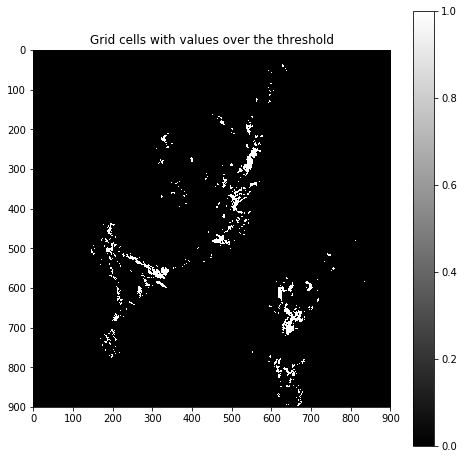

In [27]:
plt.imshow(ca_mask[0], interpolation='none',cmap='gray')
plt.title("Grid cells with values over the threshold")
plt.colorbar()

## Get maks of invalid data
In the first step we also got grid cells with invalid data, which where assigned the value 250 when we read the radar data. So, in the next step we get a mask of all invalid data values, to eliminate them later.

In [28]:
fill_mask = (radar_data.dbz.values==250)

Now we have a mask of all invalid data:

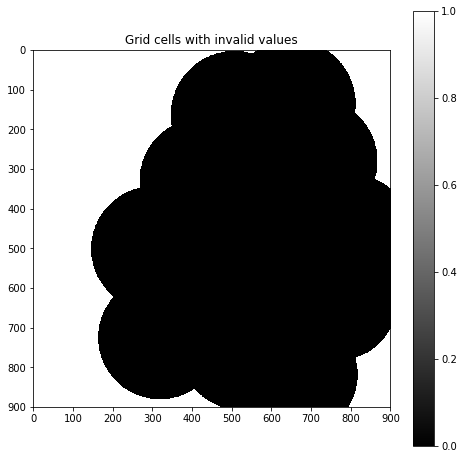

In [29]:
plt.imshow(fill_mask[100], interpolation='none',cmap='gray')
plt.title("Grid cells with invalid values")
plt.colorbar()

## Get buffer mask
The next step consists of creating buffers of a given size (in this case 15 pixels) around the convectively active grid cells to really only get isolated new developing objects. We also create a buffer around the borders of our data field to avoid recognising older objects which are drifting into our observational area as new ones. 

In [30]:
buffer_mask = hci.buffer_mask(ca_mask|fill_mask,radius=15)

This leaves us with this result:

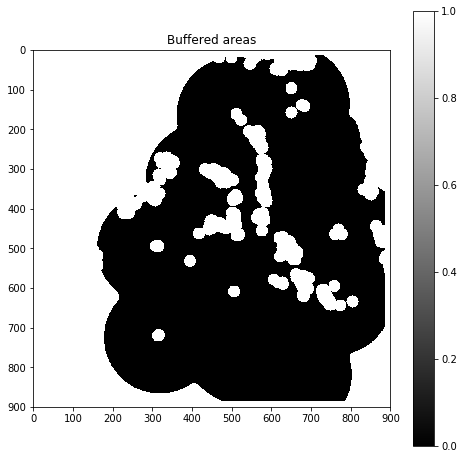

In [31]:
plt.imshow(buffer_mask[200], interpolation='none',cmap='gray')
plt.title("Buffered areas")
plt.colorbar()

## Identify new convectively active grid cells outside of the buffer mask
In the following step we take the next time step and look for grid cells with a reflectivity factor of above 35 dBZ being outside the buffered areas.

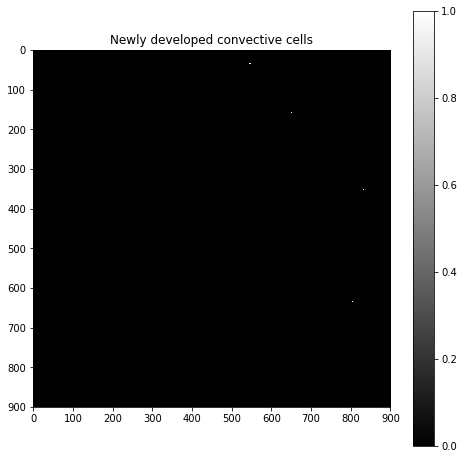

In [32]:
ci_mask = hci.ci_mask(ca_mask,buffer_mask)

plt.imshow(ci_mask[200],interpolation='none',cmap='gray')
plt.title("Newly developed convective cells")
plt.colorbar()

## Link successive time steps by connectivity
The next step consists of linking the found new convectively active pixels over a given number of successive time steps (in this case 6) to derive objects which survived for a sufficently long time.

In [35]:
#object_mask = hci.link_objects(ci_mask,ca_mask,6)
selem = np.zeros((3,3,3))
selem[1,:,:]=1
object_map, nr_obj =  hci.label_objects(ca_mask,selem)

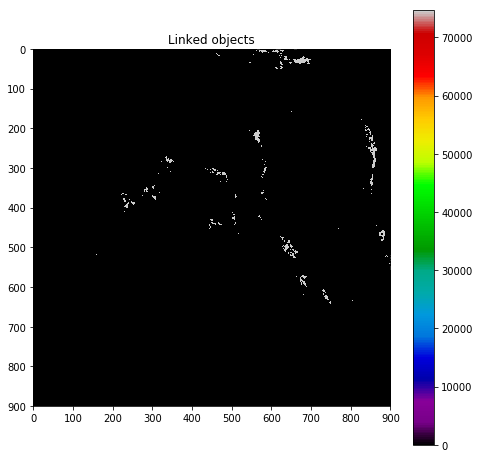

In [36]:
plt.imshow(object_map[200],interpolation='none',cmap='nipy_spectral')
plt.title("Linked objects")
plt.colorbar()

## Label objects
In the following step the derived objects are labeled, to give them a unique identificator.

In [15]:
id_map, num_obj = hci.label_objects(object_mask>0)

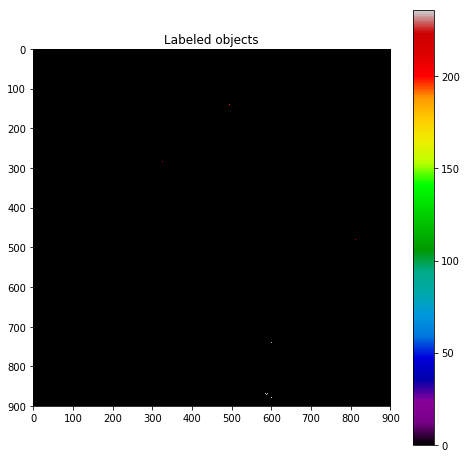

In [16]:
plt.imshow(id_map[10],interpolation='none',cmap='nipy_spectral')
plt.title("Labeled objects")
plt.colorbar()

## Get bounding box for objects
In the last step we can derive some object properties we can use for further analysis. Useful properties are e.g. object life time and the bounding box.

In [17]:
object_bbox = hci.find_objects(id_map)

In [18]:
object_bbox.head(10)

tmin  tmax  rmin  rmax  cmin  cmax
idx                                    
1       1     2   147   149   364   365
2       1     2   282   283   423   424
3       1     2   283   284   424   425
4       1     7   302   304   453   454
5       1     2   337   338   394   395
6       1     2   337   339   396   399
7       1     2   337   338   399   400
8       1     2   439   440   771   772
9       1     2   457   458   170   171
10      1     2   459   462   169   170

In this example, object 4 looks like a good candiate for isolated convection, as it fullfills the life time criterion of 6 time steps. So, let us plot it to have a closer look.

In [19]:
interesting_part = id_map[object_bbox.tmin[4]:object_bbox.tmax[4]]

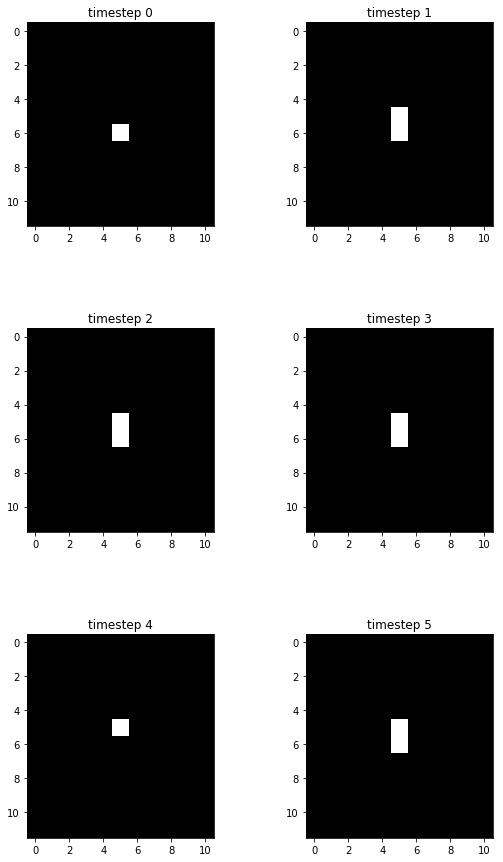

In [20]:
fig, axs = plt.subplots(3,2, figsize=(10, 15))
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in xrange(len(interesting_part)):
    axs[i].imshow(interesting_part[i][object_bbox.rmin[4]-5:object_bbox.rmax[4]+5,
                                      object_bbox.cmin[4]-5:object_bbox.cmax[4]+5],
                  cmap="gray")
    axs[i].set_title("timestep %s"% i)

So, as this object does not seem to move and also does not grow very much, it is probably not an object worth considering.